In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import glob
import os

# RetinaFace Anchors

In [96]:
class RetinaFace:
    def __init__(self):
        self.fpn_keys = []
        self._feat_stride_fpn = [32, 16, 8]
        _ratio = (1.,)
        self.anchor_cfg = {
          '32': {'SCALES': (32,16), 'BASE_SIZE': 16, 'RATIOS': _ratio, 'ALLOWED_BORDER': 9999},
          '16': {'SCALES': (8,4), 'BASE_SIZE': 16, 'RATIOS': _ratio, 'ALLOWED_BORDER': 9999},
          '8': {'SCALES': (2,1), 'BASE_SIZE': 16, 'RATIOS': _ratio, 'ALLOWED_BORDER': 9999},
        }
        
#         self._feat_stride_fpn = [64, 32, 16, 8, 4]
#         self.anchor_cfg = {}
#         _ass = 2.0**(1.0/3)
#         _basescale = 1.0
#         _ratio = (1.,1.5)
#         for _stride in [4, 8, 16, 32, 64]:
#             key = str(_stride)
#             value = {'BASE_SIZE': 16, 'RATIOS': _ratio, 'ALLOWED_BORDER': 9999}
#             scales = []
#             for _ in range(3):
#                 scales.append(_basescale)
#                 _basescale *= _ass
#             value['SCALES'] = tuple(scales)
#             self.anchor_cfg[key] = value

        print(self._feat_stride_fpn, self.anchor_cfg)

        for s in self._feat_stride_fpn:
            self.fpn_keys.append('stride%s'%s)
        dense_anchor = False
        self._anchors_fpn = dict(zip(self.fpn_keys, generate_anchors_fpn(dense_anchor=dense_anchor, cfg=self.anchor_cfg)))
        for k in self._anchors_fpn:
          v = self._anchors_fpn[k].astype(np.float32)
          self._anchors_fpn[k] = v

In [97]:
r = RetinaFace()

([32, 16, 8], {'32': {'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (32, 16)}, '8': {'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (2, 1)}, '16': {'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (8, 4)}})


In [98]:
r.fpn_keys

['stride32', 'stride16', 'stride8']

In [101]:
r.anchor_cfg['8']

{'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (2, 1)}

In [102]:
r._anchors_fpn[r.fpn_keys[0]]

array([[-248., -248.,  263.,  263.],
       [-120., -120.,  135.,  135.]], dtype=float32)

In [103]:
def size_of_anchor(anchor):
    w = anchor[2] - anchor[0] +1
    h = anchor[3] - anchor[1] +1
    return w,h

In [104]:
all_sizes = []
for i in range(3):
    sizes = map(size_of_anchor,r._anchors_fpn[r.fpn_keys[i]])
    all_sizes.extend(sizes)

In [105]:
all_sizes

[(512.0, 512.0),
 (256.0, 256.0),
 (128.0, 128.0),
 (64.0, 64.0),
 (32.0, 32.0),
 (16.0, 16.0)]

In [106]:
def ratios(anchor):
    return anchor[1]/anchor[0]

In [107]:
ratios_ = map(ratios,all_sizes)

In [108]:
ratios_

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# OurData

In [41]:
labels = open('./label.txt','r')

In [49]:
def get_ouranchors(labels_path):
    fi = open(labels_path,'r')
    anchors = []
    for line in fi:
        s = line.strip()
        if s[-4:] == '.jpg':
            continue
        s = line.strip().split(' ')
        anchors.append((float(s[2]),float(s[3])))
    fi.close()
    return anchors

In [50]:
o_anchors = get_ouranchors('./label.txt')

In [51]:
o_anchors

[(28.0, 22.0),
 (21.0, 22.0),
 (14.0, 19.0),
 (19.0, 24.0),
 (16.0, 14.0),
 (21.0, 28.0),
 (23.0, 23.0),
 (21.0, 24.0),
 (93.0, 110.0),
 (33.0, 71.0),
 (21.0, 38.0),
 (19.0, 30.0),
 (22.0, 30.0),
 (31.0, 48.0),
 (19.0, 18.0),
 (55.0, 53.0),
 (11.0, 8.0),
 (12.0, 8.0),
 (12.0, 15.0),
 (12.0, 15.0),
 (46.0, 57.0),
 (103.0, 104.0),
 (13.0, 17.0),
 (15.0, 21.0),
 (8.0, 11.0),
 (9.0, 12.0),
 (19.0, 22.0),
 (21.0, 22.0),
 (13.0, 18.0),
 (14.0, 18.0),
 (17.0, 22.0),
 (44.0, 54.0),
 (73.0, 77.0),
 (13.0, 13.0),
 (10.0, 10.0),
 (12.0, 14.0),
 (11.0, 12.0),
 (11.0, 16.0),
 (14.0, 17.0),
 (20.0, 22.0),
 (17.0, 16.0),
 (11.0, 16.0),
 (8.0, 11.0),
 (14.0, 17.0),
 (10.0, 15.0),
 (24.0, 14.0),
 (13.0, 14.0),
 (36.0, 38.0),
 (10.0, 12.0),
 (11.0, 12.0),
 (15.0, 21.0),
 (18.0, 26.0),
 (16.0, 21.0),
 (8.0, 12.0),
 (12.0, 17.0),
 (10.0, 12.0),
 (6.0, 7.0),
 (17.0, 21.0),
 (88.0, 97.0),
 (9.0, 12.0),
 (65.0, 90.0),
 (37.0, 97.0),
 (36.0, 78.0),
 (21.0, 28.0),
 (16.0, 20.0),
 (15.0, 16.0),
 (10.0, 12.0),
 

In [64]:
o_ratios = []
max_size = -1
min_size = 3000
width_d = {}
widths = []
heights = []
for i,anchor in enumerate(o_anchors):
    o_ratios.append(anchor[1]/anchor[0])
    widths.append(anchor[0])
    heights.append(anchor[1])
    if anchor[0]>max_size:
        max_size = anchor[0]
    if anchor[0]<min_size:
        min_size = anchor[0]
    if anchor[0] in width_d:
        width_d[anchor[0]] +=1
    else:
        width_d[anchor[0]] = 1

In [65]:
max_size

179.0

In [66]:
min_size

2.0

In [67]:
import matplotlib.pyplot as plt

(array([   1.,   15.,   16.,   46.,   91.,  132.,  164.,  172.,  228.,
         246.,  182.,  174.,  140.,  133.,  108.,   96.,   98.,   99.,
          77.,   64.,   68.,   60.,   46.,   57.,   45.,   39.,   39.,
          31.,   42.,   29.,   26.,   25.,   21.,   16.,   24.,   23.,
          21.,   17.,   14.,   10.,    8.,   12.,   10.,    7.,   11.,
           9.,   14.,    6.,    6.,    4.,    6.,    3.,    9.,    5.,
           4.,    0.,    2.,    5.,    2.,    3.,    4.,    8.,    9.,
           3.,    2.,    4.,    1.,    4.,    2.,    0.,    1.,    2.,
           0.,    4.,    2.,    4.,    1.,    3.,    4.,    1.,    2.,
           2.,    0.,    1.,    0.,    0.,    1.,    0.,    1.,    0.,
           0.,    0.,    1.,    0.,    1.,    0.,    0.,    1.,    0.,
           0.,    0.,    0.,    2.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

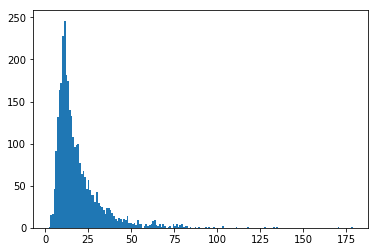

In [179]:
plt.hist(widths,bins = 179)

In [145]:
keys = sorted(width_d.keys())

In [82]:
# count = 0
all_c = 0
max_count = 0
max_i = -1
for key in keys :
#     if key<13:
#         count += width_d[key]
#     all_c += width_d[key]
    if width_d[key]> max_count:
        max_count = width_d[key]
        max_i = key

In [83]:
count

1293

In [84]:
all_c

0

In [85]:
max_count

246

In [86]:
max_i

11.0

(array([  2.40000000e+01,   4.74000000e+02,   1.41200000e+03,
          9.38000000e+02,   2.10000000e+02,   4.50000000e+01,
          1.80000000e+01,   1.00000000e+01,   7.00000000e+00,
          1.00000000e+00]),
 array([ 0.42857143,  0.71904762,  1.00952381,  1.3       ,  1.59047619,
         1.88095238,  2.17142857,  2.46190476,  2.75238095,  3.04285714,
         3.33333333]),
 <a list of 10 Patch objects>)

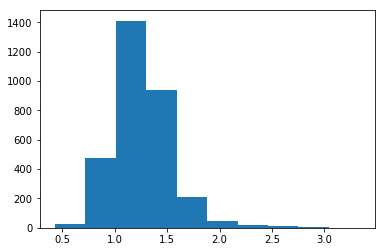

In [87]:
plt.hist(o_ratios)

In [109]:
for an in all_sizes:
    if an[0] >180:
        print(an)

(512.0, 512.0)
(256.0, 256.0)


In [110]:
len(all_sizes)

6

In [112]:
r._anchors_fpn['stride8']

array([[ -8.,  -8.,  23.,  23.],
       [  0.,   0.,  15.,  15.]], dtype=float32)

In [116]:
for i in range(3):
    print(r.fpn_keys[i])
    print(r._anchors_fpn[r.fpn_keys[i]])
    print(map(size_of_anchor,r._anchors_fpn[r.fpn_keys[i]]))
    print('*'*20)

stride32
[[-248. -248.  263.  263.]
 [-120. -120.  135.  135.]]
[(512.0, 512.0), (256.0, 256.0)]
********************
stride16
[[-56. -56.  71.  71.]
 [-24. -24.  39.  39.]]
[(128.0, 128.0), (64.0, 64.0)]
********************
stride8
[[ -8.  -8.  23.  23.]
 [  0.   0.  15.  15.]]
[(32.0, 32.0), (16.0, 16.0)]
********************


In [118]:
K = {'stride32':[32,43],'stride16':[64,86],'stride8':[128,171]}

In [119]:
for key in K.keys():
    size = K[key][0] *K[key][1]
    print(key)
    print(size)

stride32
1376
stride16
5504
stride8
21888


In [148]:
keys.insert(0,0)

In [151]:
width_d[0] = 0

In [154]:
cum_sum = [0]
for key in keys[1:]:
    last = cum_sum[-1]
    cum_sum.append(last+width_d[key])

In [155]:
cum_sum

[0,
 1,
 16,
 32,
 78,
 169,
 301,
 465,
 637,
 865,
 1111,
 1293,
 1467,
 1607,
 1740,
 1848,
 1944,
 2042,
 2141,
 2218,
 2282,
 2350,
 2410,
 2456,
 2513,
 2558,
 2597,
 2636,
 2667,
 2709,
 2738,
 2764,
 2789,
 2810,
 2826,
 2850,
 2873,
 2894,
 2911,
 2925,
 2935,
 2943,
 2955,
 2965,
 2972,
 2983,
 2992,
 3006,
 3012,
 3018,
 3022,
 3028,
 3031,
 3040,
 3045,
 3049,
 3051,
 3056,
 3058,
 3061,
 3065,
 3073,
 3082,
 3085,
 3087,
 3091,
 3092,
 3096,
 3098,
 3099,
 3101,
 3105,
 3107,
 3111,
 3112,
 3115,
 3119,
 3120,
 3122,
 3124,
 3125,
 3126,
 3127,
 3128,
 3129,
 3130,
 3132,
 3133,
 3134,
 3135,
 3136,
 3137,
 3138,
 3139]

<Container object of 94 artists>

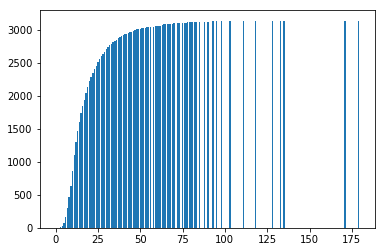

In [156]:
plt.bar(keys,cum_sum)

In [157]:
total_sum = cum_sum[-1]

In [158]:
total_sum

3139

In [162]:
percen = np.array(cum_sum,float)/total_sum

In [166]:
for i in range(len(percen)):
    if percen[i]>0.99:
        print(i)
        break

73


In [172]:
percen[15]

0.58872252309652751

In [171]:
keys[15]

16.0

In [17]:
def generate_anchors(base_size=16, ratios=[0.5, 1, 2],
                     scales=2 ** np.arange(3, 6), stride=16, dense_anchor=False):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """

    base_anchor = np.array([1, 1, base_size, base_size]) - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in range(ratio_anchors.shape[0])])
    if dense_anchor:
      assert stride%2==0
      anchors2 = anchors.copy()
      anchors2[:,:] += int(stride/2)
      anchors = np.vstack( (anchors, anchors2) )
    #print('GA',base_anchor.shape, ratio_anchors.shape, anchors.shape)
    return anchors

#def generate_anchors_fpn(base_size=[64,32,16,8,4], ratios=[0.5, 1, 2], scales=8):
#    """
#    Generate anchor (reference) windows by enumerating aspect ratios X
#    scales wrt a reference (0, 0, 15, 15) window.
#    """
#    anchors = []
#    _ratios = ratios.reshape( (len(base_size), -1) )
#    _scales = scales.reshape( (len(base_size), -1) )
#    for i,bs in enumerate(base_size):
#      __ratios = _ratios[i]
#      __scales = _scales[i]
#      #print('anchors_fpn', bs, __ratios, __scales, file=sys.stderr)
#      r = generate_anchors(bs, __ratios, __scales)
#      #print('anchors_fpn', r.shape, file=sys.stderr)
#      anchors.append(r)
#    return anchors

def generate_anchors_fpn(dense_anchor=False, cfg = None):
    #assert(False)
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """
    if cfg is None:
      from ..config import config
      cfg = config.RPN_ANCHOR_CFG
    RPN_FEAT_STRIDE = []
    for k in cfg:
      RPN_FEAT_STRIDE.append( int(k) )
    RPN_FEAT_STRIDE = sorted(RPN_FEAT_STRIDE, reverse=True)
    anchors = []
    for k in RPN_FEAT_STRIDE:
      v = cfg[str(k)]
      bs = v['BASE_SIZE']
      __ratios = np.array(v['RATIOS'])
      __scales = np.array(v['SCALES'])
      stride = int(k)
      #print('anchors_fpn', bs, __ratios, __scales, file=sys.stderr)
      r = generate_anchors(bs, __ratios, __scales, stride, dense_anchor)
      #print('anchors_fpn', r.shape, file=sys.stderr)
      anchors.append(r)

    return anchors

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr


def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchors


def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors


def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors